In [1]:
import pandas as pd
from fontTools.mtiLib import parseLookup
from sklearn.ensemble import RandomForestRegressor
# Reading and formatting data.
# Load the dataset and standardize column names to lowercase
# to ensure consistent and convenient feature handling.
df = pd.read_csv(r"[YOUR PATH TO DATASET]", encoding='latin1')
df.columns = df.columns.str.lower()

# Inspect dataset size and preview the first rows
# to verify data integrity after loading.

print("Len of Dataframe:\n", len(df))
print("Dataframe(head):\n", df.head())

# Review data types to identify numerical and categorical features.

df.dtypes

Len of Dataframe:
 35768
Dataframe(head):
       city      price                  address  number_beds  number_baths  \
0  Toronto   779900.0    #318 -20 SOUTHPORT ST          3.0           2.0   
1  Toronto   799999.0    #818 -60 SOUTHPORT ST          3.0           1.0   
2  Toronto   799900.0  #714 -859 THE QUEENSWAY          2.0           2.0   
3  Toronto  1200000.0         275 MORTIMER AVE          4.0           2.0   
4  Toronto   668800.0    #420 -388 RICHMOND ST          1.0           1.0   

  province  population  latitude  longitude  median_family_income  
0  Ontario   5647656.0   43.7417   -79.3733               97000.0  
1  Ontario   5647656.0   43.7417   -79.3733               97000.0  
2  Ontario   5647656.0   43.7417   -79.3733               97000.0  
3  Ontario   5647656.0   43.7417   -79.3733               97000.0  
4  Ontario   5647656.0   43.7417   -79.3733               97000.0  


city                     object
price                   float64
address                  object
number_beds             float64
number_baths            float64
province                 object
population              float64
latitude                float64
longitude               float64
median_family_income    float64
dtype: object

In [2]:
# Identify rows with missing values to assess data quality.
print(df.isna().any(axis=1).sum())

# Inspect affected rows to understand the nature of missing data.

rows_missing = df[df.isna().any(axis=1)]
print(rows_missing)

# Inspection shows that these rows contain malformed records
# where all values were shifted into a single column.
# Such rows account for approximately 0.13% of the dataset,
# so removing them is unlikely to affect the overall analysis.


46
                                                    city  price address  \
35154  Sherbrooke,599999,"5413-5415-5417, rue Dorion"...    NaN     NaN   
35165  Sherbrooke,299900,"201-203, rue Olivier",5,3,Q...    NaN     NaN   
35186  Sherbrooke,5.00E+05,"1082, rue Saint-Marc",8,4...    NaN     NaN   
35190  Sherbrooke,540000,"891-899, rue Larocque",3,1,...    NaN     NaN   
35192  Sherbrooke,1125000,"3668-3674, rue Nicolas-Sch...    NaN     NaN   
35196  Sherbrooke,797000,"1-2-3-4-5, rue Codère",11,2...    NaN     NaN   
35198  Sherbrooke,419000,"2363-2365, rue Forest",5,2,...    NaN     NaN   
35222  Sherbrooke,399000,"1458-1460, rue Mirka",4,2,Q...    NaN     NaN   
35235  Sherbrooke,665000,"4690-4692, chemin de North ...    NaN     NaN   
35236  Sherbrooke,339900,"1326-1328, rue Belvédère Su...    NaN     NaN   
35237  Sherbrooke,785000,"317-319, rue Saint Francis"...    NaN     NaN   
35242  Sherbrooke,349000,"359, 6e Avenue",7,7,Quebec,...    NaN     NaN   
35246  Sherbrooke,2199

In [3]:
df = df.dropna()
len(df)

35722

In [4]:
# Next step: remove duplicates
#1) Find amount of duplicates
#2) Drop duplicates
#3) Check len of clean dataset
print("Duplicates found:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("Len after:", len(df))
#Some rows were removed due this step. This is a significant loss of data but duplicates are useless
#and even dangerous for statistics

Duplicates found: 2505
Len after: 33217


In [5]:
# Next step: explore 'price'
#1) Make output price easy to read
#2) Get basic price statistic
pd.set_option('display.float_format', '{:.2f}'.format)
print(df['price'].describe())

# Price is the key variable for this project,
# so the next steps will analyze how other features influence it.

count      33217.00
mean      978502.63
std      1042407.28
min        21500.00
25%       495000.00
50%       724900.00
75%      1125000.00
max     37000000.00
Name: price, dtype: float64


In [6]:
# Next step: format prices for histograms

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Raw price values are too large for visual perception on histograms.
# This formatter converts prices into a readable format (k / M)
# and will be reused across multiple visualizations.

def price_formatter(x,pos):
    if x >= 1000000:
        return f"CAD{x/1000000:.1f}M"
    elif x >= 1000:
        return f"CAD{x/1000:.0f}k"
    else:
        return f"CAD{x:.0f}"


#plt.hist(df['price'], bins=50)
#plt.xlabel('price')
#plt.ylabel('Number of houses')
#plt.title('Housing Prices')

#formatter = FuncFormatter(price_formatter)
#plt.gca().xaxis.set_major_formatter(formatter)
#plt.xticks(rotation=45)

#plt.show()

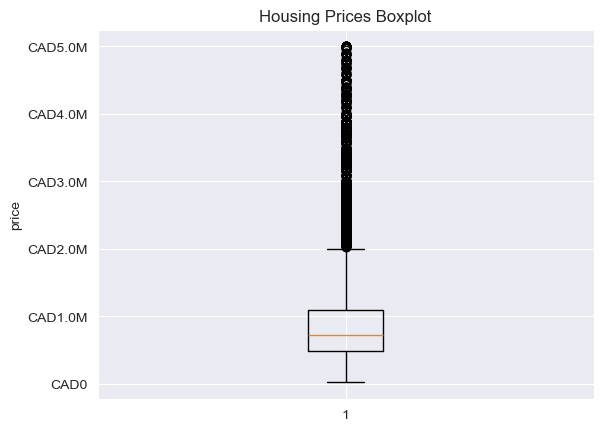

In [7]:
# Next step: filter prices
# Visual inspection shows that statistical outliers start above ~CAD2.0M.
# However, the price range between CAD5.0M and CAD10.0M forms a long right tail,
# which severely distorts data visualisation.
# Therefore, prices were capped at CAD5.0M for exploratory analysis.
df_price_filtered = df[df['price'] <=5000000]

plt.boxplot(df_price_filtered['price'])
plt.ylabel('price')
plt.title('Housing Prices Boxplot')

formatter = FuncFormatter(price_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()


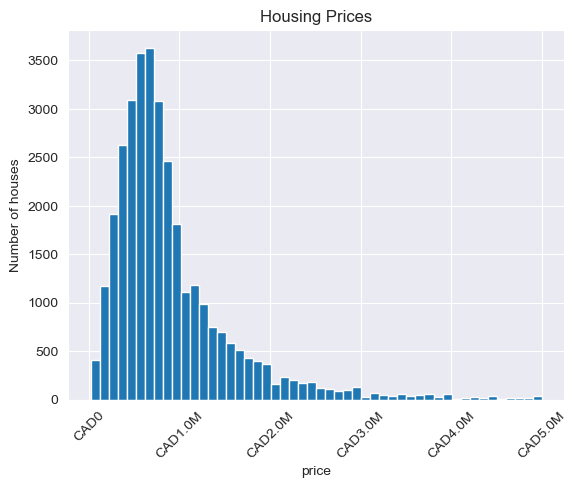

In [8]:
# Next step: pricing visualisation
# The histogram below indicates that the average price segment is located
# between CAD300k and CAD1.0M. The values after this mark
# show a sharp decline and form a smoothly decreasing tail.
# After CAD3.0M, only isolated values are observed, which,
# are still part of the market.

plt.hist(df_price_filtered['price'], bins=50)
plt.xlabel('price')
plt.ylabel('Number of houses')
plt.title('Housing Prices')

formatter = FuncFormatter(price_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xticks(rotation=45)
plt.show()

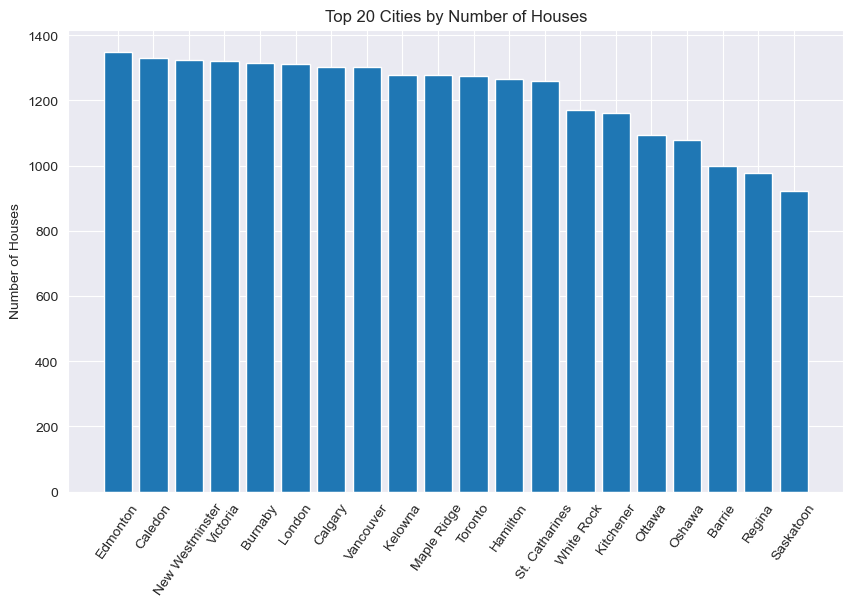

In [9]:
# Next step: checking statistical fairness
# Different cities have different numbers of listings and pricing.
# This histogram shows the top-20 cities by number of houses,
# highlighting natural differences in data coverage, which is acceptable.
city_counts = df['city'].value_counts().head(20)
plt.figure(figsize = (10,6))
plt.bar(city_counts.index, city_counts.values)
plt.xticks(rotation=55)
plt.title("Top 20 Cities by Number of Houses")
plt.ylabel("Number of Houses")
plt.show()

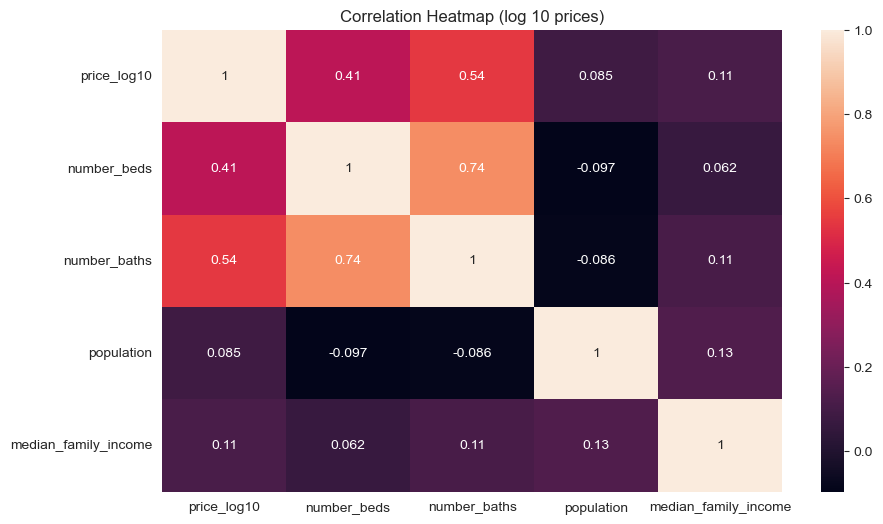

In [10]:
# Next step: building correlation
# After data is checked, the correlation between price and other signs
# will be sufficiently objective. However, some prices
# may distort the results, so logarithmic values will be used instead.
# In future visualizations, I will often resort to this.
# Correlation shows that prices are not so dependent on other signs,
# the most significant connection is with number of beds and baths.
# In turn, baths and beds are naturally strongly connected.
import seaborn as sns
import numpy as np
df['price_log10'] = np.log10(df['price'])
num_df = df.select_dtypes(include=['int64', 'float64'])
num_df = num_df.drop(columns=['longitude','latitude', 'price'])

cols = ['price_log10'] + [c for c in num_df.columns if c != 'price_log10']
num_df = num_df[cols]

plt.figure(figsize = (10,6))
sns.heatmap(num_df.corr(), annot=True)
plt.title('Correlation Heatmap (log 10 prices)')
plt.show()

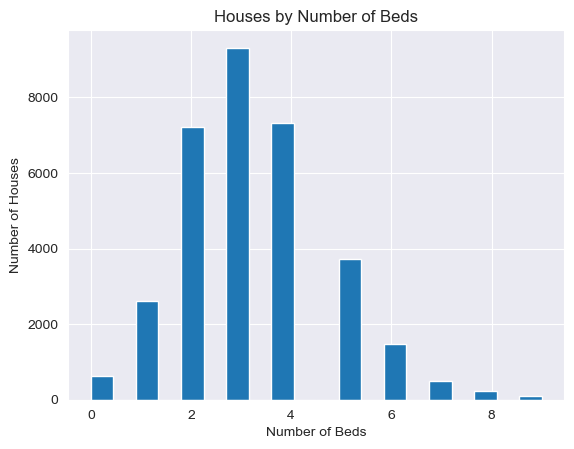

In [11]:
# Next step: statistics about bedrooms
# Bedrooms have a strong influence on house prices, so it's important to
# analyze how many bedrooms houses usually have.
# Visual analysis has shown that values over 10 are rare
# and create a long tail that distorts the histogram.
# The majority of houses have 2, 3, or 4 bedrooms, which likely reflects
# Canadian preferences for family homes with extra space for guests.
# It may also indicate that some houses are bought for renting out
# rooms to students or immigrants.

beds_under10 = df[df['number_beds']<10]
plt.hist(beds_under10['number_beds'], bins=20)
plt.xlabel('Number of Beds')
plt.ylabel('Number of Houses')
plt.title('Houses by Number of Beds')

plt.show()

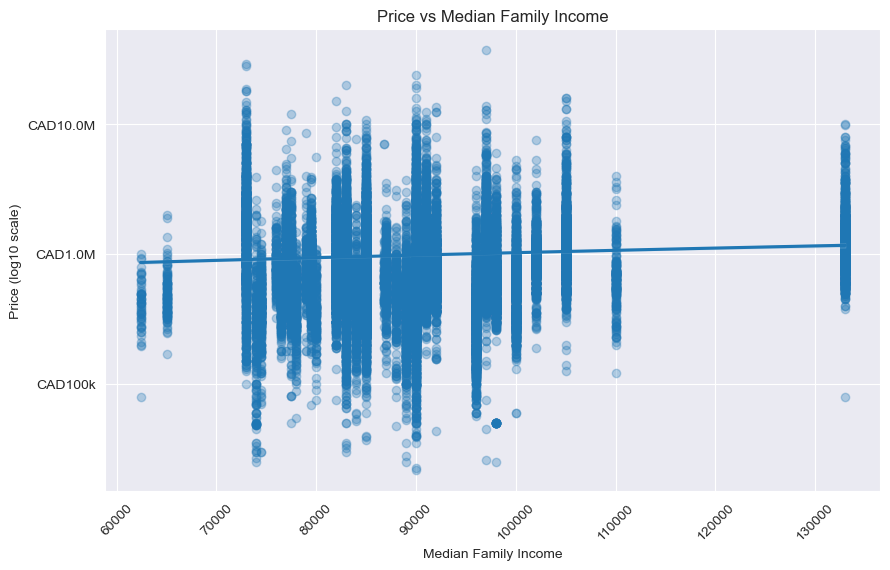

In [12]:
# Hypothesis 1:
# "Median family income must affect house pricing in province"
# Generally, median family income does not affect prices significantly,
# according to the previous heatmap. However, this question needs
# more details to be answered clearly.
# The histogram below has a regression which confirms low
# correlation between prices and family income. Moreover,
# the points are scattered along the x-axis without a clear pattern,
# confirming the weak correlation.

plt.figure(figsize = (10,6))
sns.regplot(data=df, x='median_family_income', y='price', scatter_kws={'alpha':0.3})
plt.yscale('log', base=10)
plt.xlabel('Median Family Income')
plt.ylabel('Price (log10 scale)')
plt.title('Price vs Median Family Income')

formatter = FuncFormatter(price_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)

plt.show()

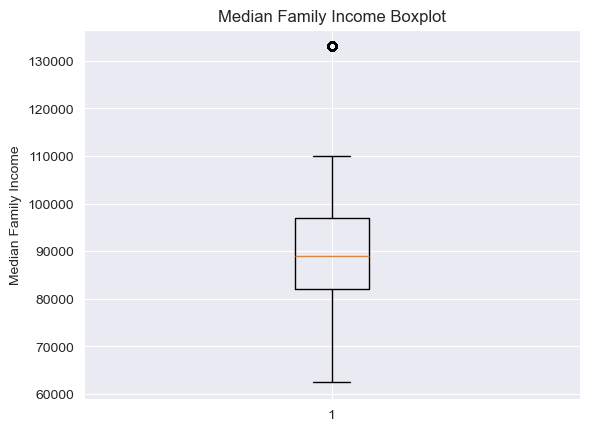

In [13]:
# The boxplot highlights the cluster of unusually high median family income,
# showing that data is not uniform across all cities.
# This sets the stage for analyzing whether larger cities tend to have higher housing prices.

plt.boxplot(df['median_family_income'])
plt.ylabel('Median Family Income')
plt.title('Median Family Income Boxplot')
plt.show()

In [14]:
# Hypothesis 2:
# "Housing prices are expected to increase with city size"
# The dataset contains column 'population' which may be used
# for city size classification. To identify categories 'small',
# 'medium' and 'large' were used quantiles of 'population'.
# q1 is 25th percentile and q3 is 75th percentile.
# This approach provides an objective classification.

q1 = df['population'].quantile(0.25)
q3 = df['population'].quantile(0.75)

conditions = [
    df['population'] <= q1,
    (df['population'] > q1) & (df['population'] <= q3),
    df['population'] > q3,
]

size = ['small', 'medium', 'large']

df['city_size'] = np.select(conditions, size, default='NA')


                mean    median  count
city_size                            
large      940859.79 649900.00   7203
medium     894512.24 704900.00  16811
small     1161389.06 819900.00   9203


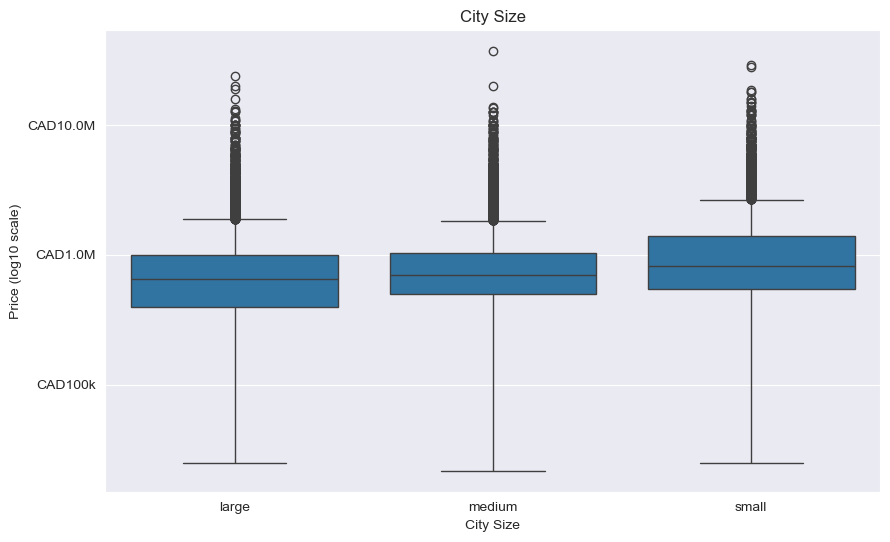

In [15]:
# Compare city categories by housing prices using numeric statistics and a boxplot.
# Observation: small towns are, on average, more expensive than medium or large cities.
# The 'small' category also contains more observations than the 'large' one.
# The boxplot highlights differences and anomalies. The number of outliers across all
# categories is similar, so anomalies are not the reason for higher prices in small towns.
print(df.groupby('city_size')['price'].agg(['mean', 'median', 'count']))

plt.figure(figsize = (10,6))
sns.boxplot(x='city_size', y='price', data=df)
plt.yscale('log', base=10)
plt.xlabel('City Size')
plt.ylabel('Price (log10 scale)')
plt.title('City Size')

formatter = FuncFormatter(price_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

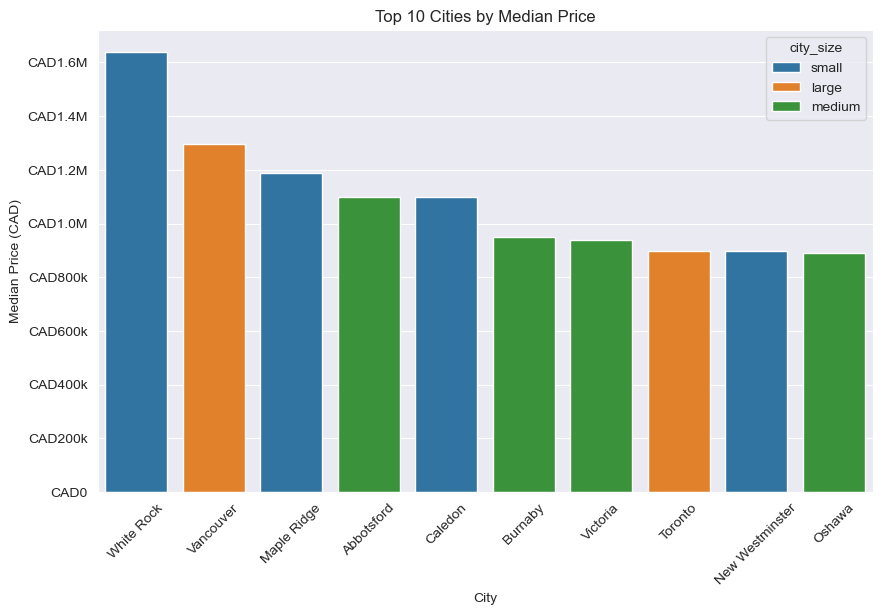

In [16]:
# The histogram shows that 4 out of the top 10 cities by median price
# belong to the 'small' category, with 3 of them appearing in the top 5.
# White Rock stands out as the most expensive city, significantly exceeding
# Vancouver in median price.

# This suggests that the previously observed higher prices in small cities
# are driven by a limited number of premium markets rather than a general
# price increase across all small towns.
# This finding contradicts the initial assumption and indicates that city size alone
# does not determine pricing. Instead, a small number of premium markets
# disproportionately affect the results.

city_prices = df.groupby(['city', 'city_size'])['price'].median().reset_index()
city_prices = city_prices.sort_values(by=['price'], ascending=False).head(10)

plt.figure(figsize = (10,6))
sns.barplot(x='city', y='price', hue='city_size', data=city_prices, dodge=False)

plt.xlabel('City')
plt.ylabel('Median Price (CAD)')
plt.title('Top 10 Cities by Median Price')

formatter = FuncFormatter(price_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)

plt.show()

In [17]:
# Hypothesis 3:
# The number of bedrooms and bathrooms affects housing prices.
# The tables below provide numeric statistics for these features.
# The most common configurations are 3 bedrooms and 2 bathrooms.
# After these points, the number of houses drops significantly,
# while prices tend to increase.
# However, for high room counts the sample size becomes too small,
# making average prices less reliable.

df_beds_pricing = df.groupby('number_beds')['price'].agg(['mean', 'median', 'count'])
print(df_beds_pricing)

                   mean      median  count
number_beds                               
0.00          673830.65   399900.00    625
1.00          519669.05   499900.00   2617
2.00          681559.46   599900.00   7220
3.00          846434.75   698900.00   9317
4.00         1104089.89   889949.50   7318
5.00         1426620.85  1099000.00   3727
6.00         1675321.21  1299999.00   1484
7.00         2181894.28  1699000.00    493
8.00         2190721.51  1790000.00    239
9.00         2254814.64  2199000.00     89
10.00        2137033.97  1800000.00     31
11.00        2229968.75  1874950.00     16
12.00        2172331.83  2073625.00     12
13.00        1950000.00  1950000.00      1
14.00        1480000.00  1480000.00      1
15.00        2015733.33  1084900.00      6
16.00        2809400.00  2400000.00      5
17.00        6699500.00  6699500.00      2
18.00         998900.00   998900.00      1
20.00        2449966.67  2400000.00      3
21.00        4750000.00  4750000.00      1
26.00      

In [18]:
df_baths_pricing = df.groupby('number_baths')['price'].agg(['mean', 'median', 'count'])
print(df_baths_pricing)

                    mean      median  count
number_baths                               
0.00           755241.91   429500.00    518
1.00           544617.32   479900.00   6175
2.00           762092.52   649900.00  11387
3.00          1014642.96   829000.00   8400
4.00          1308191.67  1100000.00   4773
5.00          2097305.12  1749900.00   1087
6.00          2852323.07  2288944.00    482
7.00          3715364.68  2699999.00    173
8.00          4053798.01  3250000.00    106
9.00          4563520.68  3398888.00     69
10.00         3972687.38  3944000.00     16
11.00         9935743.11  6850000.00      9
12.00         4219070.00  3349950.00     10
14.00         2248000.00  2248000.00      1
15.00         3750000.00  3750000.00      1
16.00         4599999.67  4800000.00      3
17.00        12500000.00 12500000.00      1
20.00         3050000.00  3050000.00      1
21.00         4750000.00  4750000.00      1
22.00         4345000.00  4345000.00      2
25.00         4350000.00  435000

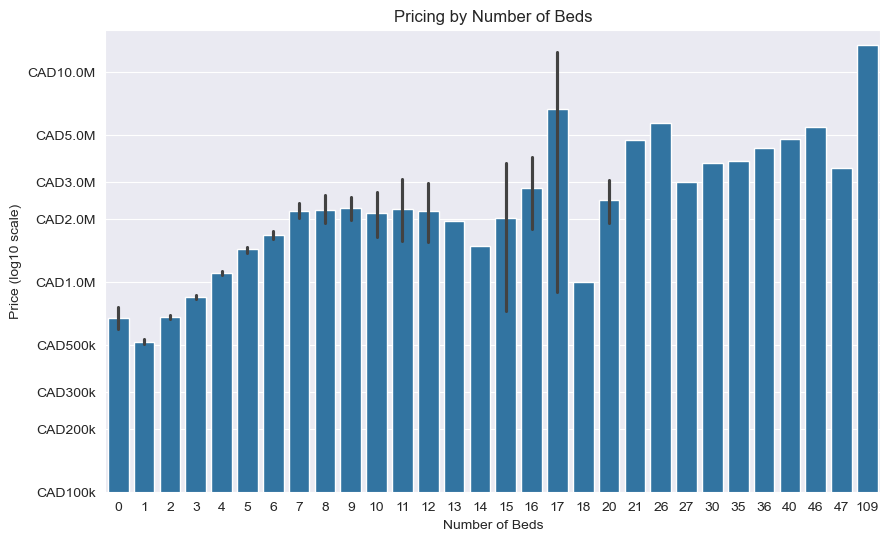

In [19]:
# Getting deeper into the topic of rooms, the bar plots below illustrate
# the relationship between the number of bedrooms, bathrooms, and housing prices.
# Both features demonstrate a positive association with price up to approximately
# 5–6 rooms, after which the number of observations decreases sharply and price
# variability increases, reducing statistical reliability.

# According to the correlation analysis, the number of bedrooms and bathrooms
# exhibits relatively strong correlations with housing prices compared to other
# numerical features in the dataset. At the same time, bedrooms and bathrooms
# are strongly correlated with each other.

# Bathrooms show a slightly stronger association with price than bedrooms,
# which may reflect their role as a comfort and quality indicator rather than
# a basic necessity.

# Overall, room counts are informative features, but their explanatory power
# diminishes at higher values and they should not be treated as independent
# drivers of price.

df['number_beds'] = df['number_beds'].astype('int')

plt.figure(figsize = (10,6))
sns.barplot(x='number_beds', y='price', data=df)
plt.yscale('log', base=10)
plt.yticks([100000, 200000, 300000, 500000,
            1000000, 2000000, 3000000, 5000000,
            10000000],
           ['100k','200k','300k','500k',
            '1M','2M','3M','5M','10M'])
plt.xlabel('Number of Beds')
plt.ylabel('Price (log10 scale)')
plt.title('Pricing by Number of Beds')

formatter = FuncFormatter(price_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()


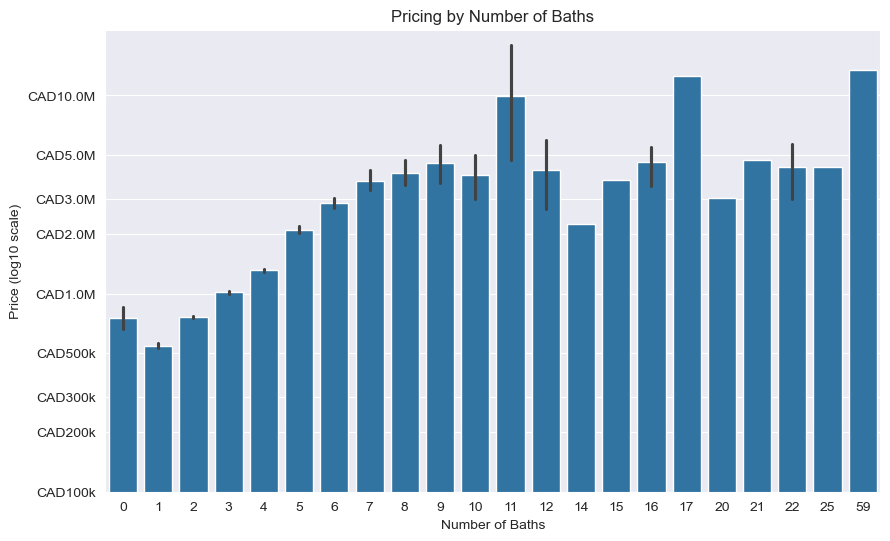

In [20]:
df['number_baths'] = df['number_baths'].astype('int')

plt.figure(figsize = (10,6))
sns.barplot(x='number_baths', y='price', data=df)
plt.yscale('log', base=10)
plt.yticks([100000, 200000, 300000, 500000,
            1000000, 2000000, 3000000, 5000000,
            10000000],
           ['100k','200k','300k','500k',
            '1M','2M','3M','5M','10M'])
plt.xlabel('Number of Baths')
plt.ylabel('Price (log10 scale)')
plt.title('Pricing by Number of Baths')

formatter = FuncFormatter(price_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

In [21]:
# Hypothesis 4:
# Housing prices may depend on the province.

# Summary statistics indicate substantial differences in median housing prices
# across provinces. Provinces with a larger number of listings tend to have
# higher median prices, which may be associated with the presence of major
# metropolitan areas.

# At the same time, provinces with comparable numbers of listings may exhibit
# different price levels (e.g., Quebec and Manitoba), suggesting that provincial
# differences are not solely driven by sample size.

df_pp = df.groupby('province')['price'].agg(['mean', 'median', 'count'])
print(df_pp)

                                mean    median  count
province                                             
Alberta                    531302.78 439849.50   3858
British Columbia          1365221.64 974900.00  11159
Manitoba                   481774.02 399900.00    523
New Brunswick              422932.49 372500.00    643
Newfoundland and Labrador  438451.01 389900.00    655
Nova Scotia                794771.09 604900.00     91
Ontario                    956324.95 775000.00  13847
Quebec                     603543.19 494999.50    548
Saskatchewan               402668.39 349900.00   1893


Province Population vs Number of Houses Correlation 0.8206093351909735


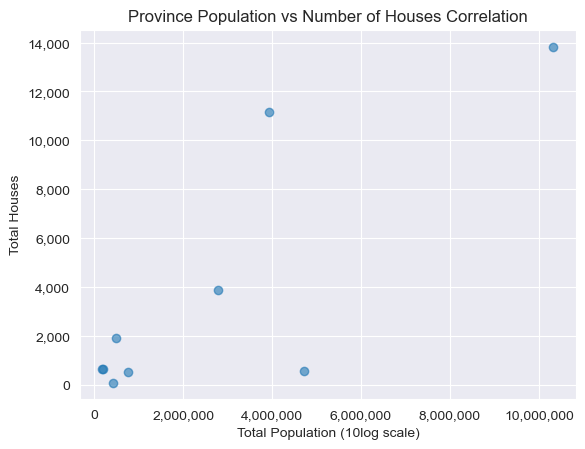

                    province  total_houses  total_population
0                    Alberta          3858        2795151.00
1           British Columbia         11163        3933173.00
2                   Manitoba           524         758515.00
3              New Brunswick           643         189680.00
4  Newfoundland and Labrador           652         185565.00
5                Nova Scotia            91         431479.00
6                    Ontario         13840       10325899.00
7                     Quebec           548        4720488.00
8               Saskatchewan          1898         492545.00


In [22]:
# To assess data coverage, the relationship between provincial population and
# number of listings was examined. A positive correlation is observed, indicating
# that listing counts generally scale with population.

# However, some provinces (e.g., Quebec) appear underrepresented relative to their
# population size, which limits the reliability of price estimates and requires
# cautious interpretation of results for these regions.

houses_per_city = df.groupby('city').size().reset_index(name='num_houses')
houses_per_city['population'] = df.groupby('city')['population'].first().values
houses_per_city['province'] = df.groupby('city')['province'].first().values

prov_data = houses_per_city.groupby('province').agg(
    total_houses=('num_houses', 'sum'),
    total_population=('population', 'sum')
).reset_index()

corr = prov_data['total_population'].corr(prov_data['total_houses'])

import matplotlib.ticker as mtick

print("Province Population vs Number of Houses Correlation", corr)
plt.scatter(prov_data['total_population'], prov_data['total_houses'], alpha=0.6)
plt.xlabel('Total Population (10log scale)')
plt.ylabel('Total Houses')
plt.title('Province Population vs Number of Houses Correlation')

plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.show()

print(prov_data)

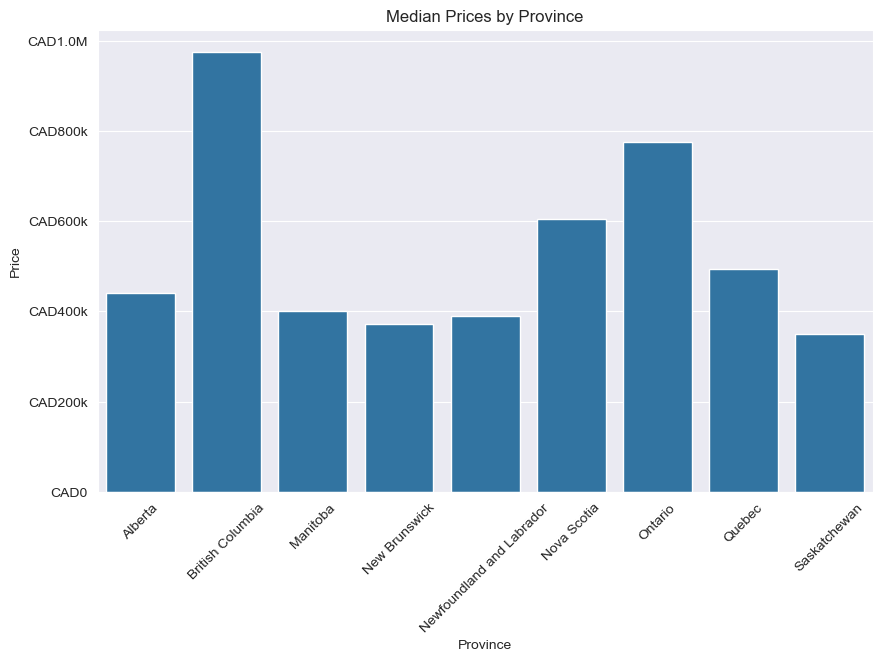

In [23]:
# The bar plot of median prices highlights that while a few provinces exhibit
# distinctly higher prices, most provinces remain relatively comparable.

# Differences in mean log-transformed prices across provinces are
# statistically significant (ANOVA, p < 0.05), indicating that
# provincial location effects are unlikely to be due to random variation alone,
# suggesting that provincial location is a relevant
# factor for housing prices. Given the skewed price distribution,
# this result should be interpreted with caution.

# Overall, province-level effects appear meaningful and are therefore included
# as categorical features in the subsequent predictive model.

median_prices = df.groupby('province')['price'].median().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(x='province', y='price', data=median_prices)
plt.xlabel('Province')
plt.ylabel('Price')
plt.title('Median Prices by Province')
plt.xticks(rotation=45)

formatter = FuncFormatter(price_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

In [24]:
from scipy.stats import f_oneway

groups = [
    np.log1p(df[df['province'] == prov]['price'])
    for prov in df['province'].unique()
]

f_stat, p_val = f_oneway(*groups)

print("F=", f_stat)
print("p=", p_val)

F= 1558.331352545878
p= 0.0


In [25]:
# Machine Learning Model
# The purpose of this model is not to achieve maximum predictive accuracy,
# but to validate insights obtained during exploratory data analysis.

# Previous analysis suggested that housing prices are influenced by a
# combination of structural features (bedrooms, bathrooms), location-related
# factors (city and province), and socioeconomic indicators.

# A Random Forest Regressor is used to capture potential nonlinear relationships
# and interactions between these features. Housing prices are log-transformed
# to reduce skewness and mitigate the impact of extreme values.

# Categorical location features (province, city, city size) are encoded using
# one-hot encoding. Model performance is evaluated using MAE and RMSE on a
# held-out test set.

# Feature importance scores are examined to assess whether the model's behavior
# aligns with the findings from EDA.

df = pd.get_dummies(df, columns=['province', 'city', 'city_size'], drop_first=True)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

base_features = ['number_beds', 'number_baths', 'population', 'median_family_income']
dummy_features = [col for col in df.columns if col.startswith('province_')
                  or col.startswith('city_')
                  or col.startswith('city_size_')]

X = df[base_features + dummy_features]
y = np.log1p(df['price'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(random_state=42, n_estimators=300)
model.fit(X_train, y_train)

pred = np.expm1(model.predict(X_test))
y_test_real = np.expm1(y_test)

mae = mean_absolute_error(y_test_real, pred)
rmse = mean_squared_error(y_test_real, pred, squared=False)

print("MAE=", mae)
print("RMSE=", rmse)

importances = model.feature_importances_
for name, value in zip(X.columns, importances):
    print(f"{name}: {value:.4f}")

MAE= 310903.3635322984
RMSE= 821075.327469564
number_beds: 0.0660
number_baths: 0.4258
population: 0.0513
median_family_income: 0.0368
province_British Columbia: 0.1468
province_Manitoba: 0.0002
province_New Brunswick: 0.0002
province_Newfoundland and Labrador: 0.0004
province_Nova Scotia: 0.0011
province_Ontario: 0.1781
province_Quebec: 0.0117
province_Saskatchewan: 0.0008
city_Airdrie: 0.0003
city_Barrie: 0.0008
city_Brantford: 0.0002
city_Burnaby: 0.0020
city_Caledon: 0.0009
city_Calgary: 0.0016
city_Edmonton: 0.0006
city_Guelph: 0.0011
city_Halifax: 0.0012
city_Hamilton: 0.0005
city_Kamloops: 0.0082
city_Kelowna: 0.0040
city_Kingston: 0.0008
city_Kitchener: 0.0005
city_Lethbridge: 0.0004
city_London: 0.0004
city_Maple Ridge: 0.0005
city_Medicine Hat: 0.0001
city_Moncton: 0.0003
city_Montreal: 0.0018
city_Nanaimo: 0.0050
city_New Westminster: 0.0005
city_Oshawa: 0.0003
city_Ottawa: 0.0034
city_Peterborough: 0.0002
city_Prince George: 0.0102
city_Quebec: 0.0001
city_Red Deer: 0.0015


C:\Users\anton\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
